In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from dataset import SatelliteDataset
from UNet import UNet

EPOCH = 1000
LEARNING_RATE = 0.01
BATCH_SIZE = 1
IMAGE_SIZE = (400, 400)
VAL_SPILIT = 0.1
TEST_SPLIT = 0.1
RANDOM_SEED = 42
DEVICE = 'cuda'
PATH = 'basic'

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

2024-04-28 18:38:40.134067: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-28 18:38:40.136245: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-28 18:38:40.168890: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 18:38:40.168911: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 18:38:40.169711: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Dataset

In [2]:
dataset = SatelliteDataset('Train', IMAGE_SIZE, transform=True)

train_size = int((1 - VAL_SPILIT - TEST_SPLIT) * len(dataset))
val_size = int(VAL_SPILIT * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_iterator = iter(test_dataloader)

# Model

In [4]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
model = to_device(UNet(in_channels=3, out_channels=1, init_features=32), DEVICE)
state_dict = torch.load('checkpoints/UNet_420.pth')
model.load_state_dict(state_dict)

for param in model.parameters():
    param.requires_grad = False

# Vis

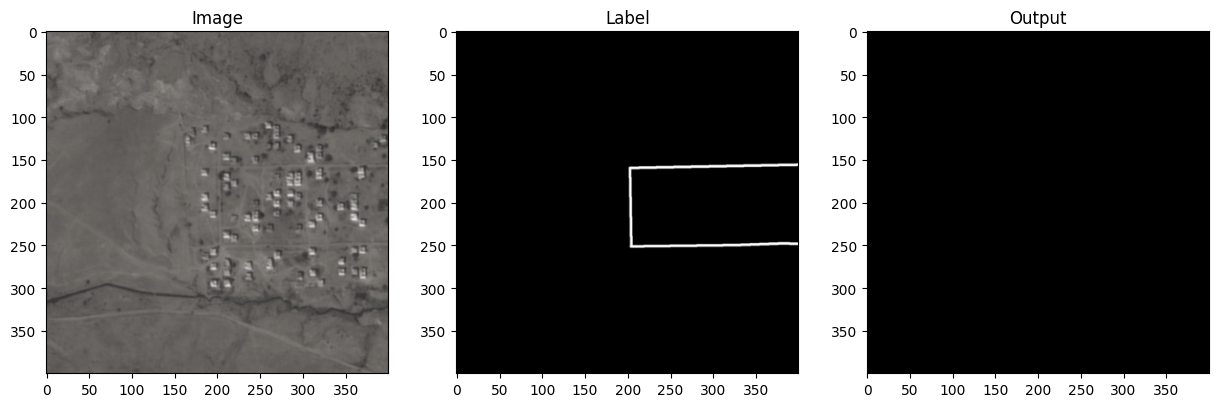

In [5]:

def show_next_sample(model):
    images, labels = next(test_iterator)
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    outputs = model(images)

    image = images.cpu().numpy()[0]
    label = labels.cpu().numpy()[0]
    output = outputs.cpu().numpy()[0]

    image = np.transpose(image, (1, 2, 0))
    label = np.transpose(label, (1, 2, 0))
    output = np.transpose(output, (1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    image = image * std + mean
    image = np.clip(image, 0, 1)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(image)
    axs[0].set_title('Image')

    axs[1].imshow(label, cmap='gray')
    axs[1].set_title('Label')

    axs[2].imshow(output, cmap='gray')
    axs[2].set_title('Output')

    plt.show()

show_next_sample(model)